In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import yfinance as yf

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df = yf.download("PETR4.SA", start="2010-01-01", end="2024-10-11")
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2024-10-04 00:00:00+00:00,37.840000,37.840000,38.200001,37.669998,38.150002,22526800
2024-10-07 00:00:00+00:00,38.369999,38.369999,38.380001,37.900002,38.040001,36418000
2024-10-08 00:00:00+00:00,37.599998,37.599998,37.750000,37.450001,37.470001,34142000
2024-10-09 00:00:00+00:00,37.220001,37.220001,37.520000,37.009998,37.369999,30789800
2024-10-10 00:00:00+00:00,37.650002,37.650002,37.740002,37.320000,37.400002,20630100


In [4]:
data = df['Adj Close'].values #.reshape(-1, 1)

In [5]:
# Step 1: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [6]:
window_size = 35
horizen = 14


# Function to create sequences
def create_sequences(data, window_size, horizen):
    X, y = [], []
    for i in range(len(data) - window_size - horizen):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size] < data[i + window_size + horizen])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size, horizen)



# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


In [7]:
# Split into train and test
train_split = 0.8
y_train = y[: int(train_split * y.shape[0])]
y_test = y[int(train_split * y.shape[0]) :]

X_train = X[: int(train_split * y.shape[0])]
X_test = X[int(train_split * y.shape[0]) :]

print(f'Shape of the train data {X_train.shape}')
print(f'Shape of the test data {X_test.shape}')

Shape of the train data torch.Size([2897, 35, 1])
Shape of the test data torch.Size([725, 35, 1])


In [8]:

# Step 2: Create Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# vamos usar estes numeros mais adiante para calcular a acuracia
test_N = len(test_loader.dataset)
train_N = len(train_loader.dataset)

In [9]:
next(iter(train_loader))[0].shape

torch.Size([32, 35, 1])

In [10]:
# Model parameters
input_size = 1       # Input feature size
hidden_size = 50     # LSTM hidden state size
num_layers = 2       # Number of LSTM layers
output_size = 1      # Output size (for binary classification)
seq_length = window_size   # Length of the input sequence

# Define the custom model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, seq_length):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(hidden_size * seq_length, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.flatten(lstm_out)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, seq_length)

# Move the model to the device
model = model.to(device)


In [11]:
def get_batch_accuracy(output, y, N):
    pred = (output > 0.5).float()
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [12]:

class_weight = {0: 1 / (1 - torch.mean(y_train)), 1: 1.0}
print(class_weight)
pos_weight = torch.tensor([class_weight[0]], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

{0: tensor(2.1161), 1: 1.0}


In [14]:


# Step 5: Training the Model
num_epochs = 100

for epoch in range(num_epochs):
    accuracy = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy += get_batch_accuracy(outputs, batch_y, len(train_loader.dataset))
    

    if (epoch+1) % 10 == 0:
        print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))




Train - Loss: 0.8007 Accuracy: 0.5285
Train - Loss: 1.0260 Accuracy: 0.5274
Train - Loss: 0.8542 Accuracy: 0.5274
Train - Loss: 1.1220 Accuracy: 0.5274
Train - Loss: 0.8542 Accuracy: 0.5274
Train - Loss: 0.9307 Accuracy: 0.5274
Train - Loss: 0.8924 Accuracy: 0.5274
Train - Loss: 0.9690 Accuracy: 0.5274
Train - Loss: 0.9690 Accuracy: 0.5274
Train - Loss: 0.8924 Accuracy: 0.5274


              precision    recall  f1-score   support

         0.0       0.36      0.51      0.42       264
         1.0       0.63      0.48      0.55       461

    accuracy                           0.49       725
   macro avg       0.50      0.50      0.48       725
weighted avg       0.53      0.49      0.50       725

Accuracy: 0.4924
Precision: 0.6325
Recall: 0.4816
F1 Score: 0.5468


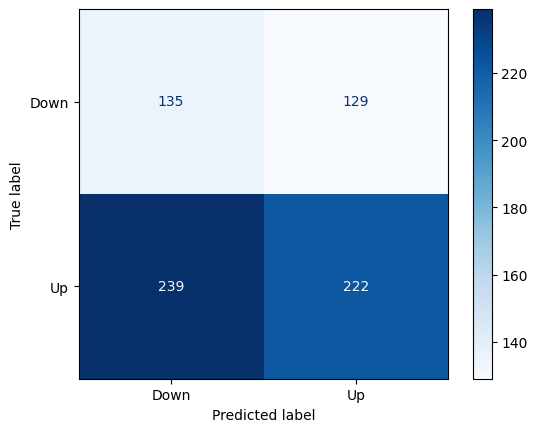

In [15]:
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np

# Assuming you have a test DataLoader `test_loader`
y_true = []
y_prob = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch).squeeze()
        y_prob.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Convert to numpy arrays
y_prob = np.array(y_prob)
y_true = np.array(y_true)

# Apply threshold to convert probabilities to binary predictions (0 or 1)
y_pred = np.round(y_prob)

# Generate and display the confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm_display.plot(values_format="", cmap="Blues")

# Print the classification report
print(classification_report(y_true, y_pred))

# Additional metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
